# Include Weather Data

reference: https://github.com/yashu-seth/pytorch-tabular

Include all possible dimensions and train a treebased classifier

In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error,mean_squared_error

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [90]:
import math

In [145]:
import scipy.stats as ss
import seaborn as sns

## Load Data

In [113]:
df = pd.read_csv('/Users/leima/data_store/rideindego_all.csv')
df['date'] = pd.to_datetime(df.date)
df_weather = pd.read_csv('data/philadelphia_weather.csv')[['date', 'hour', 'avg_temp', 'avg_humid', 'avg_wind_speed', 'avg_pressure']]
df_weather['date'] = pd.to_datetime(df_weather.date)
df = pd.merge(df, df_weather, how='left', left_on=['date', 'hour'], right_on=['date', 'hour'])

/Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,3,4,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [114]:
df.head()

,bike_id,bike_type,duration,end_lat,end_lon,end_station_id,end_time,passholder_type,plan_duration,start_lat,...,trip_id,trip_route_category,date,hour,weekday,month,avg_temp,avg_humid,avg_wind_speed,avg_pressure
0,3640,standard,4.0,39.9384,-75.173271,3064,7/1/2016 0:11,Indego30,30,39.946331,...,25183529,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
1,3349,standard,8.0,39.94138,-75.145638,3026,7/1/2016 0:18,Indego30,30,39.95295,...,25183528,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
2,5279,standard,17.0,39.933151,-75.162483,3034,7/1/2016 0:28,Indego30,30,39.93082,...,25183527,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
3,5198,standard,25.0,39.94138,-75.145638,3026,7/1/2016 0:38,Walk-up,0,39.94138,...,25183526,Round Trip,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
4,3382,standard,45.0,39.947109,-75.166183,3010,7/1/2016 0:58,Walk-up,0,39.954239,...,25183525,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6


In [115]:
df = df[df.bike_type == 'standard']
coi = [
    'plan_duration', 
    'trip_route_category', 'hour', 'weekday', 'month', 'avg_temp', 'avg_wind_speed', 'avg_pressure'
]
#avg_humid is correlated to the hour of the day
cot = ['duration']
df = df[coi+cot]
df.dropna(inplace=True)

In [116]:
df.head()

,plan_duration,trip_route_category,hour,weekday,month,avg_temp,avg_wind_speed,avg_pressure,duration
0,30,One Way,0,4,7,78.1,9.2,1016.6,4.0
1,30,One Way,0,4,7,78.1,9.2,1016.6,8.0
2,30,One Way,0,4,7,78.1,9.2,1016.6,17.0
3,0,Round Trip,0,4,7,78.1,9.2,1016.6,25.0
4,0,One Way,0,4,7,78.1,9.2,1016.6,45.0


In [117]:
df.describe()

,plan_duration,hour,weekday,month,avg_temp,avg_wind_speed,avg_pressure,duration
count,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06
mean,4.475853e+01,1.388563e+01,2.853611e+00,7.048581e+00,6.489027e+01,9.139138e+00,1.017669e+03,2.267813e+01
std,8.025856e+01,4.992925e+00,1.929616e+00,2.940383e+00,1.667288e+01,5.093160e+00,6.865514e+00,6.828042e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.100000e+00,0.000000e+00,9.837000e+02,1.000000e+00
25%,3.000000e+01,1.000000e+01,1.000000e+00,5.000000e+00,5.310000e+01,5.800000e+00,1.013400e+03,8.000000e+00
50%,3.000000e+01,1.500000e+01,3.000000e+00,7.000000e+00,6.800000e+01,8.470000e+00,1.017600e+03,1.200000e+01
75%,3.000000e+01,1.800000e+01,4.000000e+00,9.000000e+00,7.810000e+01,1.265000e+01,1.022000e+03,1.900000e+01
max,3.650000e+02,2.300000e+01,6.000000e+00,1.200000e+01,9.700000e+01,4.683000e+01,1.044400e+03,1.440000e+03


Check correlations

In [118]:
# df['duration'] = df.duration.apply(lambda x: int(math.ceil(x/5)*5))
df['duration'] = df.duration.apply(lambda x: int(x))

In [119]:
df.head()

,plan_duration,trip_route_category,hour,weekday,month,avg_temp,avg_wind_speed,avg_pressure,duration
0,30,One Way,0,4,7,78.1,9.2,1016.6,4
1,30,One Way,0,4,7,78.1,9.2,1016.6,8
2,30,One Way,0,4,7,78.1,9.2,1016.6,17
3,0,Round Trip,0,4,7,78.1,9.2,1016.6,25
4,0,One Way,0,4,7,78.1,9.2,1016.6,45


In [143]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

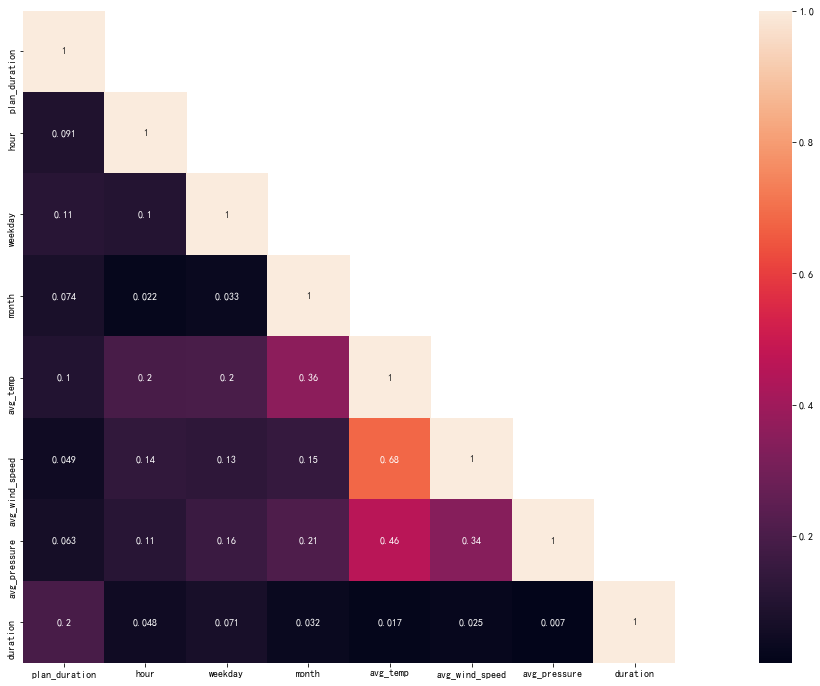

In [146]:
#cor_mat = df.corr(method='kendall')
cor_mat = df.corr(method=cramers_v)
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [121]:
for i in df.columns:
    print(
        i, ': ',
        df[i].isnull().any()
    )

plan_duration :  False
trip_route_category :  False
hour :  False
weekday :  False
month :  False
avg_temp :  False
avg_wind_speed :  False
avg_pressure :  False
duration :  False


In [122]:
scaler = StandardScaler()

In [123]:
X = df[coi]
#X = pd.get_dummies(X)
y = df[cot]
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42
    #,stratify=Y
)

In [124]:
class MultiColumnLabelEncoder:
    def __init__(self, encoders = None, columns = None):
        self.columns = columns # array of column names to encode
        if encoders:
            self.encoders = encoders
        else:
            self.encoders = {}

    def fit(self,X,y=None):
        self.check_encoders = []
        return self # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                _le = LabelEncoder()
                if self.encoders.get(col):
                    output[col] = self.encoders.get(col).transform(output[col])
                else:
                    output[col] = _le.fit_transform(output[col])
                    print(f'1. preparing encoder for {col}')
                    self.encoders[col] = _le
                    self.check_encoders.append({col: _le})
        else:
            for colname,col in output.iteritems():
                _le = LabelEncoder()
                if self.encoders.get(col):
                    output[colname] = self.encoders.get(col).transform(col)
                else:
                    output[colname] = _le.fit_transform(col)
                    print(f'2. preparing encoder for {col}')
                    self.encoders[col] = _le
                    self.check_encoders.append({col: _le})
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [203]:
encoders_obj = MultiColumnLabelEncoder(columns=coi)
df_transformed = encoders_obj.fit_transform(df)
dt_encoders = encoders_obj.encoders

1. preparing encoder for plan_duration
1. preparing encoder for trip_route_category
1. preparing encoder for hour
1. preparing encoder for weekday
1. preparing encoder for month
1. preparing encoder for avg_temp
1. preparing encoder for avg_wind_speed
1. preparing encoder for avg_pressure


In [126]:
coi

['plan_duration',
 'trip_route_category',
 'hour',
 'weekday',
 'month',
 'avg_temp',
 'avg_wind_speed',
 'avg_pressure']

In [127]:
df_transformed.head()

,plan_duration,trip_route_category,hour,weekday,month,avg_temp,avg_wind_speed,avg_pressure,duration
0,3,0,0,4,6,1054,195,249,3
1,3,0,0,4,6,1054,195,249,7
2,3,0,0,4,6,1054,195,249,16
3,0,1,0,4,6,1054,195,249,24
4,0,0,0,4,6,1054,195,249,44


In [128]:
X_trans = df_transformed[coi]
y_trans = df_transformed[cot]

X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(
    X_trans, y_trans,
    test_size=0.3, random_state=42
    #,stratify=Y
)

## NN

In [129]:
from torch.utils.data import Dataset, DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F

In [130]:


class TabularDataset(Dataset):
  def __init__(self, data, cat_cols=None, output_col=None):
    """
    Characterizes a Dataset for PyTorch

    Parameters
    ----------

    data: pandas data frame
      The data frame object for the input data. It must
      contain all the continuous, categorical and the
      output columns to be used.

    cat_cols: List of strings
      The names of the categorical columns in the data.
      These columns will be passed through the embedding
      layers in the model. These columns must be
      label encoded beforehand. 

    output_col: string
      The name of the output variable column in the data
      provided.
    """

    self.n = data.shape[0]

    if output_col:
      self.y = data[output_col].astype(np.float32).values.reshape(-1, 1)
    else:
      self.y =  np.zeros((self.n, 1))

    self.cat_cols = cat_cols if cat_cols else []
    self.cont_cols = [col for col in data.columns
                      if col not in self.cat_cols + [output_col]]

    if self.cont_cols:
      self.cont_X = data[self.cont_cols].astype(np.float32).values
    else:
      self.cont_X = np.zeros((self.n, 1))

    if self.cat_cols:
      self.cat_X = data[cat_cols].astype(np.int64).values
    else:
      self.cat_X =  np.zeros((self.n, 1))

  def __len__(self):
    """
    Denotes the total number of samples.
    """
    return self.n

  def __getitem__(self, idx):
    """
    Generates one sample of data.
    """
    return [self.y[idx], self.cont_X[idx], self.cat_X[idx]]

In [131]:
class FeedForwardNN(nn.Module):

  def __init__(self, emb_dims, no_of_cont, lin_layer_sizes,
               output_size, emb_dropout, lin_layer_dropouts):

    """
    Parameters
    ----------

    emb_dims: List of two element tuples
      This list will contain a two element tuple for each
      categorical feature. The first element of a tuple will
      denote the number of unique values of the categorical
      feature. The second element will denote the embedding
      dimension to be used for that feature.

    no_of_cont: Integer
      The number of continuous features in the data.

    lin_layer_sizes: List of integers.
      The size of each linear layer. The length will be equal
      to the total number
      of linear layers in the network.

    output_size: Integer
      The size of the final output.

    emb_dropout: Float
      The dropout to be used after the embedding layers.

    lin_layer_dropouts: List of floats
      The dropouts to be used after each linear layer.
    """

    super().__init__()

    # Embedding layers
    self.emb_layers = nn.ModuleList([nn.Embedding(x, y)
                                     for x, y in emb_dims])

    no_of_embs = sum([y for x, y in emb_dims])
    self.no_of_embs = no_of_embs
    self.no_of_cont = no_of_cont

    # Linear Layers
    first_lin_layer = nn.Linear(self.no_of_embs + self.no_of_cont,
                                lin_layer_sizes[0])

    self.lin_layers =\
     nn.ModuleList([first_lin_layer] +\
          [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
           for i in range(len(lin_layer_sizes) - 1)])
    
    for lin_layer in self.lin_layers:
      nn.init.kaiming_normal_(lin_layer.weight.data)

    # Output Layer
    self.output_layer = nn.Linear(lin_layer_sizes[-1],
                                  output_size)
    nn.init.kaiming_normal_(self.output_layer.weight.data)

    # Batch Norm Layers
    self.first_bn_layer = nn.BatchNorm1d(self.no_of_cont)
    self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size)
                                    for size in lin_layer_sizes])

    # Dropout Layers
    self.emb_dropout_layer = nn.Dropout(emb_dropout)
    self.droput_layers = nn.ModuleList([nn.Dropout(size)
                                  for size in lin_layer_dropouts])

  def forward(self, cont_data, cat_data):

    if self.no_of_embs != 0:
      x = [emb_layer(cat_data[:, i])
           for i,emb_layer in enumerate(self.emb_layers)]
      x = torch.cat(x, 1)
      x = self.emb_dropout_layer(x)

    if self.no_of_cont != 0:
      normalized_cont_data = self.first_bn_layer(cont_data)

      if self.no_of_embs != 0:
        x = torch.cat([x, normalized_cont_data], 1) 
      else:
        x = normalized_cont_data

    for lin_layer, dropout_layer, bn_layer in\
        zip(self.lin_layers, self.droput_layers, self.bn_layers):
      
      x = F.relu(lin_layer(x))
      x = bn_layer(x)
      x = dropout_layer(x)

    x = self.output_layer(x)

    return x

In [161]:
categorical_features = [
        'plan_duration',
        'trip_route_category',
        'hour',
        'weekday',
        'month'
    ]

In [162]:
dataset = TabularDataset(
    data=df_transformed, cat_cols=categorical_features, output_col=cot
)

In [163]:
dataset

In [164]:
batchsize = 128
dataloader = DataLoader(dataset, batchsize, shuffle=True, num_workers=1)

In [165]:
cat_dims = [int(df_transformed[col].nunique()) for col in categorical_features]

In [166]:
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

In [212]:
cat_dims

[5, 2, 24, 7, 12]

In [211]:
emb_dims

[(5, 3), (2, 1), (24, 12), (7, 4), (12, 6)]

In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedForwardNN(emb_dims, no_of_cont=4, lin_layer_sizes=[50, 100],
                      output_size=1, emb_dropout=0.04,
                      lin_layer_dropouts=[0.001,0.01]).to(device)

In [200]:
no_of_epochs = 5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
r2_scores = []

for epoch in range(no_of_epochs):
    r2_scores_epoch = []
    for y, cont_x, cat_x in dataloader:
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)
        y  = y.to(device)

        # Forward Pass
        preds = model(cont_x, cat_x)
        loss = criterion(preds, y)

        # Backward Pass and Optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_temp = model(cont_x, cat_x)
        r2_score_temp = metrics.r2_score(y.detach().numpy(), y_pred_temp.detach().numpy())
        r2_scores_epoch.append(r2_score_temp)
    r2_scores.append(r2_scores_epoch)
    print('Mean r2 score', np.mean(r2_scores_epoch))
        

Mean r2 score 0.8774178476009133
Mean r2 score 0.8786480298540573
Mean r2 score 0.8784017099974699
Mean r2 score 0.8832342352767376
Mean r2 score 0.8882087761634485


/Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


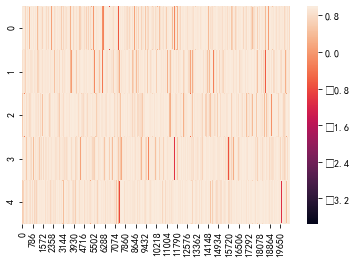

In [202]:
sns.heatmap(r2_scores)

In [172]:
y_pred_temp = model(cont_x, cat_x)

In [185]:
metrics.r2_score(y.detach().numpy(), y_pred_temp.detach().numpy())

0.9940341486221602

In [198]:
metrics.explained_variance_score(y.detach().numpy(), y_pred_temp.detach().numpy())

0.9968371987342834

In [184]:
df_temp = pd.DataFrame({'pred': [i[0] for i in y_pred_temp.detach().numpy()], 'y': [i[0] for i in y.detach().numpy()]})

Text(0, 0.5, 'Predicted Duration')

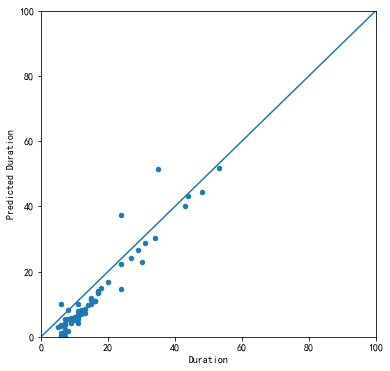

In [204]:
fig, ax = plt.subplots(figsize=(6, 6))
df_temp.plot.scatter(x='y', y='pred', ax=ax)
ax.plot(np.linspace(0,100), np.linspace(0,100))
ax.set_xlim([0,100])
ax.set_ylim([0,100])
ax.set_xlabel('Duration')
ax.set_ylabel('Predicted Duration')

Text(0, 0.5, 'Predicted Duration')

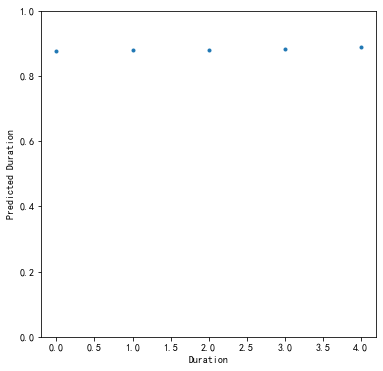

In [210]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([np.mean(i) for i in r2_scores], '.')
ax.set_ylim([0,1])
ax.set_xlabel('Duration')
ax.set_ylabel('Predicted Duration')